### MATH4480 Final Project

This final project intends to do a sentiment classification on Amazon reviews under the catagory of "Software". The analysis can also apply to other catagory. The reason to choose "Software" is because of its relatively small size.

Import necessary tools and packages for the analysis.

In [ ]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup  
import re

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Download the dataset directly from the amazon AWS.

The dataset in the tensorflow repository has complicated structures that is hard to convert to dataframe in Pandas. (Something called prefetch dataset)

In [ ]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz

--2022-05-06 05:21:35--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.6.123
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.6.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94010685 (90M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Software_v1_00.tsv.gz.1’

amazon_reviews_us_S 100%[===================>]  89.66M  42.5MB/s    in 2.1s    

2022-05-06 05:21:38 (42.5 MB/s) - ‘amazon_reviews_us_Software_v1_00.tsv.gz.1’ saved [94010685/94010685]



The download dataset is zipped, so I used gzip to unzip the data into a TSV file.

In [ ]:
data = gzip.open('amazon_reviews_us_Software_v1_00.tsv.gz')


Then I read the file using pandas' read_csv. The error_bad_lines omitted some lines that may cause error. (Probably caused by some redundent space in the file)

In [ ]:
df = pd.read_csv(data, sep='\t',error_bad_lines = False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 8021: expected 15 fields, saw 22\nSkipping line 34886: expected 15 fields, saw 22\nSkipping line 49286: expected 15 fields, saw 22\n'


We can check the first 5 rows of the dataset.

In [ ]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42605767,R3EFW2STIYIY0I,B00MUTIDKI,248732228,McAfee 2015 Internet Security 3 PC (3-Users),Software,1,2,2,N,Y,I was very disappointed with this,I was very disappointed with this. The descrip...,2015-08-31
1,US,51771800,R12NR0R5A9F7FT,B00EPACNUG,531462352,Hallmark Card Studio 2014,Software,5,0,0,N,Y,Five Stars,"I had a little struggle getting familiarized, ...",2015-08-31
2,US,16053526,R1LSH74R9XAP59,B00164AZA4,473982505,Search and Rescue 4,Software,2,0,1,N,Y,Have windows 10?,Tried to download it on my Windows 10 and it w...,2015-08-31
3,US,15319481,R1QXUNTF76K7L6,B00E6LIEFM,189774198,Quickbooks Pro,Software,2,0,0,N,Y,"Disc was corrupt, had to spend a couple hours ...","Disc was corrupt, had to spend a couple hours ...",2015-08-31
4,US,1441820,R2F7DR75PS8NKT,B00VWEBG06,852470365,Windows 7 Professional with Service Pack 1 (64...,Software,5,0,0,N,Y,Five Stars,Just what I needed. Took a little longer to sh...,2015-08-31


We see that there are in total of 15 variables.

In [ ]:
df.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtype: object

Since we only require "review_body" and "star_rating". We can drop the other variables in our analysis.

In [ ]:
df.drop("marketplace", axis = 1, inplace = True)
df.drop("customer_id", axis = 1, inplace = True)
df.drop("review_id", axis = 1, inplace = True)
df.drop("product_id", axis = 1, inplace = True)
df.drop("product_parent", axis = 1, inplace = True)
df.drop("product_title", axis = 1, inplace = True)
df.drop("product_category",axis = 1, inplace = True)
df.drop("helpful_votes",axis = 1, inplace = True)
df.drop("total_votes",axis = 1, inplace = True)
df.drop("vine",axis = 1, inplace = True)
df.drop("verified_purchase",axis = 1, inplace = True)
df.drop("review_headline",axis = 1, inplace = True)
df.drop("review_date",axis = 1, inplace = True)

The dataset becomes much clearer.

In [ ]:
df.head()

,star_rating,review_body
0,1,I was very disappointed with this. The descrip...
1,5,"I had a little struggle getting familiarized, ..."
2,2,Tried to download it on my Windows 10 and it w...
3,2,"Disc was corrupt, had to spend a couple hours ..."
4,5,Just what I needed. Took a little longer to sh...


We then checked the frequency of each values of "star_rating". The graph shows that the value of '5' is almost twice of the value of '1' and outweight other values. This is not good for Machine learning.

5    153572
1     73867
4     58556
3     30639
2     24615
Name: star_rating, dtype: int64

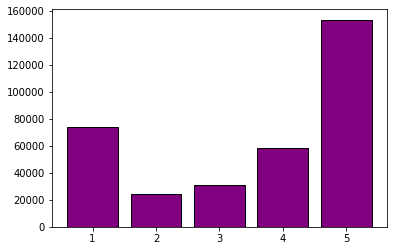

In [ ]:
plt.bar(*np.unique(df["star_rating"], return_counts=True),color='purple', edgecolor='black')
df.star_rating.value_counts()

Firstly I drop rows with missing data.

Secondly, I created an empty dataframe that collected 20000 data for each value of "star_rating". 

In [ ]:
df = df.dropna()
sample_size = 20000
df_equal = pd.DataFrame()
for i in df.star_rating.unique():
  X = df[df.star_rating == i].sample(sample_size)
  df_equal = df_equal.append(X)

1    20000
5    20000
2    20000
3    20000
4    20000
Name: star_rating, dtype: int64

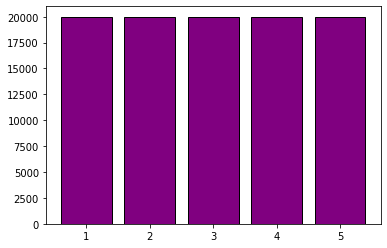

In [ ]:
plt.bar(*np.unique(df_equal["star_rating"], return_counts=True),color='purple', edgecolor='black')
df_equal.star_rating.value_counts()

Before applying those machine learning algorithms and NLP models, we have to first clean and reorganize the review_body to make the later process easier.

There are several options in cleaning the text. The first step is to remove all stopword such as "to", "I", "the" from the review. This function can be completed using the nltk.stopwords.

The second option is to lemmatize the word. For example, we need to transform the word "worst" to "bad". This function is completed using the stemming function called PorterStemmer().

The last option is to split the text.

In [ ]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

We add the clean data into the dataset

In [ ]:
df_equal['clean_review'] = df_equal.review_body.apply(cleanText)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/review/R3MNZCE7DLN8K5/ref=cm_cr_pr_cmt?ie=UTF8&ASIN=B00EFRME1C#wasThisHelpful" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Then we apply the train_test_split to our dataset, stratifying based on "star_rating".

In [ ]:
x = df_equal['clean_review']
y = df_equal['star_rating']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

Another big transformation needed is word vectorization. The simplest way will be using Bag of Words. So I used TF-IDF(Term Frequency-Inverse Document Frequency) for our analysis. The specific vectorize method is TfidfVectorizer() using unigram and bigram.

The following three pipelines are multinomial Navie Bayer model, SGD classifier, and Logistic regression respectively.

In [ ]:
mnb = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2))),
               ('clf', MultinomialNB()),
              ])

In [ ]:
sgd = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', SGDClassifier()),
               ])

In [ ]:
logreg = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=500)),
               ])

The first two models may take 1 mins while the last logistic regression can take up to 10 mins. Sorry for the inconvenience.

In [ ]:
# Multinomial Naive Bayes
mnb.fit(x_train, y_train)
y_pred_mnb = mnb.predict(x_test)
print(accuracy_score(y_test, y_pred_mnb))
print(confusion_matrix(y_test, y_pred_mnb))
print(classification_report(y_test, y_pred_mnb))

# SGD Classifier
sgd.fit(x_train, y_train)
y_pred_sgd = sgd.predict(x_test)
print(accuracy_score(y_test, y_pred_sgd))
print(confusion_matrix(y_test, y_pred_sgd))
print(classification_report(y_test, y_pred_sgd))

# Logistic Regression
logreg.fit(x_train, y_train)
y_pred_log = logreg.predict(x_test)
print(accuracy_score(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

0.4566
[[2645 1251   68   29    7]
 [1146 2404  353   85   12]
 [ 611 1860  980  486   63]
 [ 286 1030  603 1669  412]
 [ 295  613  211 1447 1434]]
              precision    recall  f1-score   support

           1       0.53      0.66      0.59      4000
           2       0.34      0.60      0.43      4000
           3       0.44      0.24      0.32      4000
           4       0.45      0.42      0.43      4000
           5       0.74      0.36      0.48      4000

    accuracy                           0.46     20000
   macro avg       0.50      0.46      0.45     20000
weighted avg       0.50      0.46      0.45     20000

0.4962
[[3335  259  166   67  173]
 [1962  817  704  229  288]
 [ 896  540 1279  692  593]
 [ 248  152  542 1184 1874]
 [ 173   61  133  324 3309]]
              precision    recall  f1-score   support

           1       0.50      0.83      0.63      4000
           2       0.45      0.20      0.28      4000
           3       0.45      0.32      0.37      400

The accuracy for those three models are 0.4566, 0.4962, and 0.528. We see that accuracy of 1-star and 5-star are much higher than the middle ratings. This is because it is hard to set a standard for everyone in those ratings. Extreme reviews are more easily identified. We set these three models as a baseline and explore some other word vectorized method.

One famous words vectorized method is using Word2Vec, but firstly we need to import the tokenizer from nltk to help us extract word from sentences.



In [ ]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

The following function parse text into sentences.

In [ ]:
def parseSent(review, tokenizer):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords = True, split_text = True))
    return sentences

We created a list called sentences that will be used to prepare the Word2Vec vocabulary list.

In [ ]:
sentences = []
for review in x_train:
    sentences += parseSent(review, tokenizer)
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

79978 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['use', 'pdf', 'converter', 'work', 'works', 'great', 'job', 'accountant', 'formating', 'adding', 'notes', 'reports', 'figured', 'give', 'shot', 'home', 'computer', 'big', 'mistake', 'seem', 'run', 'efficiently', 'laptop', 'even', 'shortcut', 'redaction', 'tool', 'bars', 'reviews', 'say', 'needs', 'enterprise', 'version', 'actually', 'think', 'version', 'might', 'better', 'one', 'installed', 'home', 'laptop', 'beefed', 'version', 'reader', 'tag', 'ocr', 'pdfs', 'exactly', 'best', 'ever', 'spent', 'paid', 'adobe', 'acrobat', 'standard']


Using those sentences from the train set, we train a vocabulary list that helps us better classify reviews in the following neural network training.

In [ ]:
num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word))
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 13979 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['software', 'program', 'use', 'product', 'version', 'would', 'one', 'get', 'windows', 'like']


In [ ]:
# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) 

Shape of embedding matrix :  (13979, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


The neural network I used is the LSTM model under the RNN catagory. I transfer the input(reviews) to numerical sequences using the trained tokenizer.

In [ ]:
top_words = embedding_matrix.shape[0]
maxlen = 100 
nb_classes = 6


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(x_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('x_train shape:', x_train_seq.shape) 
print('x_test shape:', x_test_seq.shape) 
print('y_train shape:', y_train_seq.shape) 
print('y_test shape:', y_test_seq.shape) 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


x_train shape: (80000, 100)
x_test shape: (20000, 100)
y_train shape: (80000, 6)
y_test shape: (20000, 6)


The following is the specific of the model. I used the "adam" optimizer for the training.

In [ ]:
embedding_layer = Embedding(embedding_matrix.shape[0], 
                            embedding_matrix.shape[1], 
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) 
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_seq, y_train_seq, batch_size=400, epochs=3, verbose=1, validation_data = (x_test_seq, y_test_seq))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4193700   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                                 
Total params: 4,414,122
Trainable params: 4,414,122
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
200/200 [==============================] - 89s 426ms/step - loss: 1.3764 - accuracy: 0.3802 - val_loss: 1.2079 - val_accuracy: 0.4656
Epoch 2/3
200/200 [===============

The final accuray for this model is 0.4897, which is close to the SGD classifier. For this model, it is very easy to overfit, so I only choose to use 3 epoch. I have looked up other examples doing a binary classification of positive reviews and negative reviews. The accuracy of the binary classification can reach over 90%. 

The conclusion is that the logistic model provides the highest accuracy in the multi-classification task. The word2vec method's limitation may due to the variation of the words. It is easy to reach an accuracy of 70% for the training set with the train set vocabulary. However, the testing set accuracy drop after the training set accuracy reach 60%. It may be better to generate a vocabulary list using a very large trainset and then apply to the test set.